# **Imports**

In [71]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import plot_tree

In [2]:
df = pd.read_csv("insurance.csv")

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# **Análise Exploratória**

### **Entendendo os dados**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.shape

(1338, 7)

In [5]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
df.describe(include="object").T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


### Análise exploratória dos dados

In [8]:
df.sex.value_counts()

,count
sex,
male,676
female,662


In [9]:
df.smoker.value_counts()

,count
smoker,
no,1064
yes,274


In [10]:
df.region.value_counts()

,count
region,
southeast,364
southwest,325
northwest,325
northeast,324


### Padronizando os dados para tipos numéricos

In [11]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

In [12]:
labelEncoder.fit(df.sex.drop_duplicates())
df.sex = labelEncoder.transform(df.sex)
print("Sex mapping:")
print(f"0 = {labelEncoder.inverse_transform([0])[0]}")
print(f"1 = {labelEncoder.inverse_transform([1])[0]}")

Sex mapping:
0 = female
1 = male


In [13]:
labelEncoder.fit(df.smoker.drop_duplicates())
df.smoker = labelEncoder.transform(df.smoker)
print("\nSmoker mapping:")
print(f"0 = {labelEncoder.inverse_transform([0])[0]}")
print(f"1 = {labelEncoder.inverse_transform([1])[0]}")


Smoker mapping:
0 = no
1 = yes


In [14]:
labelEncoder.fit(df.region.drop_duplicates())
df.region = labelEncoder.transform(df.region)
print("\nRegion mapping:")
for i in range(4):
    print(f"{i} = {labelEncoder.inverse_transform([i])[0]}")


Region mapping:
0 = northeast
1 = northwest
2 = southeast
3 = southwest


In [15]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


### Com os dados padronizados em numéricos, faremos a análise de correlação

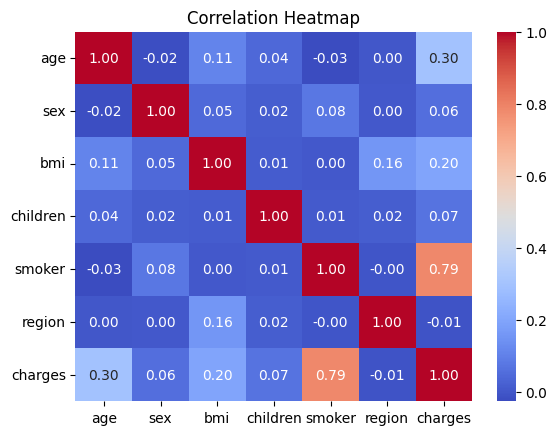

In [16]:
corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Com a análise de correlação, pode-se concluir que a coluna "smoker" tem uma forte correlação com a coluna Target "charges", vamos nos aprofundar nisso

In [17]:
for col in df.columns:
    fig = go.Figure()

    for i, (category, count) in enumerate(df[col].value_counts().items()):
        fig.add_trace(go.Bar(x=[col], y=[count], name=category))
    fig.update_layout(title=f'Distribution of {col}', xaxis_title=col, yaxis_title='Count')
    fig.show()

### Visualizando a distribuição de custo, porém agrupando por fumantes e não fumantes

In [18]:
px.histogram(
    df,
    x="charges",
    color="smoker",
    title="Distribution of Charges by Smoker Status"
)

# **Análise de Dados**

### O principal passo para a análise de dados é questionar as informações para obter respostas e insights


### Qual região possui a maior quantidade de fumantes?

In [19]:
px.histogram(
    data_frame=df,
    x='region',
    color='smoker',
    title='Distribuição de Fumantes por Região',
    color_discrete_sequence=['blue', 'red']
)

#### No dicionário das regiões, a que possui mais pacientes fumantes é a 2, "southeast"

### Qual a distribuição de fumantes pelo custo?

In [22]:
px.histogram(
    data_frame=df[df.smoker == 1],
    x="charges",
    nbins=50,
    title="Distribuição de custo para fumantes"
)

In [23]:
px.histogram(
    data_frame=df[df.smoker == 0],
    x="charges",
    nbins=50,
    title="Distribuição de custo para não fumantes"
)

#### Após a análise desses gráficos, consegue-se concluir que os pacientes que fumam gastam consideravelmente mais que os não fumantes, partindo de 12K e chegando a ultrapassar a marca dos 60k, enquanto os não fumantes não passam da marca dos 37K

### Qual gênero fuma mais? (coluna "sex")

In [24]:
px.histogram(
  data_frame=df,
  x='smoker',
  color='sex',
  barmode='group',
  color_discrete_sequence=['red', 'blue'],
  title='Distribuiçao de fumantes por genero'
)

#### Pode-se observar que existem muito mais não fumantes que fumantes, mas a quantidade de homens e mulheres em ambos os casos não é muito significativa, mesmo a maioria sendo homens

### Analisando a distribuição de fumantes por idade

In [26]:
px.histogram(
    data_frame=df,
    x='age',
    color='smoker',
    barmode='group',
    color_discrete_sequence=['red', 'blue'],
    title='Distribuiçao de fumantes por idade'
)

### Qual gênero paga mais de plano de saude?

In [27]:
px.box(
    data_frame=df,
    x='sex',
    y='charges',
    color='smoker',
    title='Distribuiçao de custo por genero'
)

#### Os homens e mulheres que fumam (caixas azuis) tem um volume muito maior de gastos com o plano de saude, mas mesmo os gêneros que nao fumam, possuem alguns outliers que acabam pagando valores altos tambem. Podemos pensar em procurar uma razão para isso, como a relação com o IMC

### Analisando a relação do custo dos não fumantes com seu IMC

In [28]:
px.scatter(
    data_frame=df[df.smoker == 0],
    x='bmi',
    y='charges',
    title='IMC vs Custo para nao fumantes',
    trendline='ols'
)

#### O gráfico nos mostra que, em media, os não fumantes pagam menos de 15 mil independente do seu IMC, porém alguns (que possuem um IMC entre 20 e 40) estão acima da média, então pode-se concluir que a obesidade e as pessoas acima do peso tem mais custos com o plano de saúde.

### Analisando as idades desses pacientes

In [29]:
px.box(
    df[df.smoker == 0],
    x='age',
    y='bmi',
    title='Distribuicao do imc por idade para nao fumantes'
)

In [30]:
px.box(
    df[df.smoker == 1],
    x='age',
    y='bmi',
    title='Distribuicao do imc por idade para fumantes'
)

#### Após a visualização dos dados, os IMCs são bem distribuídos entre as idades, mas o preocupante é que existem pacientes bem acima do peso, podendo significar obesidade. Os dados não possuem muitos outliers

### Analisando a relação das idades, gênero e fumantes

In [31]:
px.bar(
    data_frame=df,
    x="age",
    y="smoker",
    color="sex",
    title="Relacao entre idade, fumante e genero"
)

#### Mais uma visualização que comprova os homens de todas idades acabam fumando um pouco mais que as mulheres.

### Analisando se os homens que fumam pagam um valor maior de plano de saúde

In [32]:
df_smokers = df[df.smoker == 1]
df_smokers = df_smokers.groupby(['age']).agg({'charges': 'mean'}).reset_index()

fig = px.line(
    data_frame=df_smokers,
    x='age',
    y='charges',
    title='Custo médio para fumantes por idade',
    labels={'charges': 'Custo médio', 'age': 'Idade'}
)
fig.update_traces(mode='lines+markers')
fig.show()

#### Em todas as idades os que fumam estao pagando mais que 25 mil

In [33]:
df_smokers = df[df["smoker"] == 1]

fig = px.histogram(
    df_smokers,
    x="age",
    y="charges",
    nbins=30,
    title="Contagem de fumantes por idade",
    color_discrete_sequence=["crimson"]
)
fig.update_layout(
    xaxis_title="Idade",
    yaxis_title="Soma de custos"
)
fig.show()

### Concluindo que existem muitos fumantes entre 18 e 20 anos que estão pagando valores altos de plano de saude, precisamos analisar um pouco mais a fundo

In [34]:
smokers = df[(df.age >= 18) & (df.age <= 20)]

fig = px.histogram(
    data_frame=smokers,
    x="smoker",
    color="sex",
    barmode="group",
    title="O numero de fumantes entre 18 e 20 anos",
    color_discrete_sequence=["red", "blue"]
)
fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=["Não Fumante", "Fumante"]
)
fig.update_layout(
    xaxis_title="Fumante",
    yaxis_title="Quantidade"
)
fig.show()

### Quanto esses jovens pagam de plano de saude?

In [35]:
fig = px.box(
    data_frame=smokers,
    x="charges",
    y="smoker",
    orientation="h",
    color="smoker",
    title="Box para visualizar o valor pago pelos jovens"
)

fig.update_yaxes(
    tickvals=[0, 1],
    ticktext=["Não Fumantes", "Fumantes"],
    title="Fumantes"
)
fig.update_layout(
    xaxis_title="Custo",
    showlegend=False
)
fig.show()

#### Mais uma vez comprovando que os fumantes pagam valores mais elevados de plano de saúde

### Agora qual a relacao entre os não fumantes e o custo?

In [36]:
df_n_smokers = df[df.smoker == 0]

fig = px.density_contour(
    df_n_smokers,
    x="age",
    y="charges",
    color_discrete_sequence=["magenta"]
)

fig.add_trace(go.Scatter(
    x=df_n_smokers.age,
    y=df_n_smokers.charges,
    mode='markers',
    marker=dict(color='white', symbol='cross', size=6, line=dict(width=1, color='black')),
    showlegend=False
))

fig.update_layout(
    title="Distribuico de custo pelos nao fumantes",
    xaxis_title="Idade",
    yaxis_title="Custo"
)

fig.show()

#### Consegue-se ver que existe uma reta definida onde poucos casos acabam pagando valores mais elevados

### E os fumantes?

In [37]:
df_smokers = df[df.smoker == 1]

fig = px.density_contour(
    df_smokers,
    x="age",
    y="charges",
    color_discrete_sequence=["magenta"]
)

fig.add_trace(go.Scatter(
    x=df_smokers.age,
    y=df_smokers.charges,
    mode='markers',
    marker=dict(color='white', symbol='cross', size=6, line=dict(width=1, color='black')),
    showlegend=False
))

fig.update_layout(
    title="Custo por fumantes",
    xaxis_title="Idade",
    yaxis_title="Custo"
)

fig.show()

#### Existem duas grandes aglomerações de custo altas e dispersas para os fumantes, sempre com os custos mais elevados partindo de 12K

### Analisando relação com os IMCs

In [38]:
fig = px.histogram(
    df,
    x="bmi",
    nbins=40,
    title="Distribuição geral do BMI",
    color_discrete_sequence=["teal"]
)
fig.update_layout(xaxis_title="BMI", yaxis_title="Número de pacientes")
fig.show()


#### Existe um desvio padrão para para os IMCs entre 20 e 40 a maioria está localizada entre esses valores

### Analisando a distribuição do IMC para o custo

In [43]:
px.histogram(
    df,
    x="bmi",
    y="charges",
    nbins=40,
    title="Distribuição de custo para pacientes com IMC"
)

In [42]:
bmi_df = df[(df.bmi >= 20) & (df.bmi <= 40)]

fig = px.histogram(
    bmi_df,
    x="charges",
    nbins=40,
    title="Distribuição de custo para pacientes com IMC entre 20 e 40"
)

fig.show()

#### Analisando o resultado, a quantidade é considerável, pois é onde esté a maioria dos pacientes

### Analisando se o fumo impacta no IMC do paciente



In [44]:
fig = px.scatter(
    df,
    x="bmi",
    y="charges",
    color="smoker",
    title="Relação entre imc e custo",
    color_discrete_sequence=["blue", "red"]
)
fig.update_layout(xaxis_title="IMC", yaxis_title="Custo")
fig.show()

#### Pode-se concluir que a maioria dos pacientes que fumam estão entre IMCs de 30 e 40 e estão pagando valores maiores em relação aos outros pacientes não fumantes

### Analisando a relação dos custos com a distribuição dos filhos

In [45]:
fig = px.histogram(
    df,
    x="children",
    nbins=len(df["children"].unique()),
    title="Distribuição do número de filhos",
    color_discrete_sequence=["mediumvioletred"]
)
fig.update_layout(
    xaxis_title="Número de filhos",
    yaxis_title="Número de pacientes"
)
fig.show()

#### Grande parte, para ser mais exato, 574 dos pacientes, não possuem filhos, porem a distribuicao para 1, 2 e 3 filhos é bem grande

### Analisando se a quantidade de filhos impacta no custo

In [46]:
fig = px.box(
    df,
    x="children",
    y="charges",
    title="Distribuição de custo por número de filhos",
    color="children",
    color_discrete_sequence=px.colors.sequential.Viridis
)
fig.update_layout(
    xaxis_title="Número de filhos",
    yaxis_title="Custo"
)
fig.show()


#### Boa parte dos pacientes não possuem filhos, está pagando mais caro.

### Analisando se quem tem filhos tende a fumar mais

In [47]:
fig = px.histogram(
    df,
    x="children",
    color="smoker",
    barmode="group",
    title="Distribuição de fumantes por número de filhos",
    color_discrete_sequence=["blue", "red"]
)
fig.update_layout(
    xaxis_title="Número de filhos",
    yaxis_title="Contagem de pacientes",
    legend_title="Fumante (0 = Não, 1 = Sim)"
)
fig.show()

#### A maioria nao fuma mas maior parte dos fumantes sao quem nao tem filhos

### Será que eles também tendem a ter um IMC maior?

In [48]:
fig = px.histogram(
    df[df["children"] == 0],
    x="bmi",
    nbins=30,
    title="Distribuição de IMC para pacientes sem filhos",
    color_discrete_sequence=["darkorange"]
)

fig.update_layout(
    xaxis_title="IMC",
    yaxis_title="Número de pacientes"
)
fig.show()


### Qual seria o valor pago por esses pacientes que não tem filhos e fumam?

In [49]:
fig = px.box(
    df,
    x="children",
    y="charges",
    color="smoker",
    title="Custo por número de filhos (Fumantes vs Não Fumantes)",
    color_discrete_sequence=["blue", "red"]
)
fig.update_layout(
    xaxis_title="Número de filhos",
    yaxis_title="Custo",
    legend_title="Fumante (0 = Não, 1 = Sim)"
)
fig.show()


### De acordo com os insights, um padrão pode ser analisado, os pacientes que fumam acabam pagando consideravelmente mais que os demais, independentemente da região ou quantidade de filhos.

### Outro padrão possível de perceber foi que os pacientes com um IMC elevado também tendem a pagar um pouco mais em relação aos que possuem um IMC regulado, podendo significar que a obesidade e o sobrepeso tem influência em custos hospitalares

# **Pré-tratamento dos dados**

### Separação de dados para treinamento e teste

In [51]:
X = df.drop('charges', axis=1)
y = df.charges

In [52]:
X

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,3
1,18,1,33.770,1,0,2
2,28,1,33.000,3,0,2
3,33,1,22.705,0,0,1
4,32,1,28.880,0,0,1
...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1
1334,18,0,31.920,0,0,0
1335,18,0,36.850,0,0,2
1336,21,0,25.800,0,0,3


In [53]:
y

,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520
...,...
1333,10600.54830
1334,2205.98080
1335,1629.83350
1336,2007.94500


In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Padronizando os dados para evitar que o modelo seja enviezado com a estrutura dos dados

In [55]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Analisando a linha mais próxima entre os dados, conhecido como OLS (Ordinary Least Squares)

In [56]:
import statsmodels.api as sm

# Adiciona constante para o modelo
X_train_sm = sm.add_constant(X_train_scaled)
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Exibe o resumo com p-values e intervalos de confiança
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     508.7
Date:                Tue, 03 Jun 2025   Prob (F-statistic):          2.71e-308
Time:                        16:57:39   Log-Likelihood:                -10845.
No. Observations:                1070   AIC:                         2.170e+04
Df Residuals:                    1063   BIC:                         2.174e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.335e+04    187.273     71.265      0.0

# **Teste dos modelos**

### Testando o modelo de regressão linear após a análise do OLS, usando uma validação cruzada

In [59]:
CROSS_VALIDATION = KFold(n_splits=10, shuffle=False, random_state=None)

In [60]:
gs_metric = make_scorer(r2_score, greater_is_better=True)

scores = cross_val_score(
    LinearRegression(),
    X_train_scaled,
    y_train,
    scoring=gs_metric,
    cv=CROSS_VALIDATION,
    n_jobs=-1
)

print(f'R² médio (cross-val): {np.mean(scores):.4f}')
print(f'Desvio padrão: {np.std(scores):.4f}')

R² médio (cross-val): 0.7308
Desvio padrão: 0.0664


#### Após a análise do modelo de regressão linear, conclui-se que este não é um modelo eficaz para o nosso problema de prever custos médicos.

### Criando uma função para testar vários modelos de uma vez usando um dicionário de modelos e parâmetros

In [61]:
gs_metric = make_scorer(r2_score, greater_is_better=True)

def evaluate_regression_model(model, param_grid, X, y):
    """
      Executa GridSearchCV com cross-validation para
      modelos de regressão e avalia R², MAE e MSE.
    """

    grid = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring=gs_metric,
        n_iter=30,
        cv=CROSS_VALIDATION,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    grid.fit(X, y)

    best_model = grid.best_estimator_
    best_params = grid.best_params_
    best_score = grid.best_score_

    y_pred = cross_val_predict(
        best_model,
        X,
        y,
        cv=CROSS_VALIDATION,
        n_jobs=-1
    )

    y_predict = grid.predict(X_test_scaled)

    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)

    r22 = r2_score(y_test, y_predict)
    mae2 = mean_absolute_error(y_test, y_predict)
    mse2 = mean_squared_error(y_test, y_predict)
    rmse2 = np.sqrt(mse2)

    print(f"Melhores parâmetros: {best_params}")
    print(f"R²:  {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print("-------------------")
    print(f"2R²:  {r22:.4f}")
    print(f"2MAE: {mae2:.4f}")
    print(f"2MSE: {mse2:.4f}")
    print(f"2RMSE: {rmse2:.4f}")

    return {
        "best_model": best_model,
        "best_params": best_params,
        "r2": r2,
        "r22": r22,
        "mae": mae,
        "mae2": mae2,
        "mse": mse,
        "mse2": mse2,
        "rmse": rmse,
        "rmse2": rmse2,
        "gridsearch": grid
    }

In [62]:
model_dict_params = {
    Ridge(): {
        'alpha': [0.1, 1.0, 1.5, 2.0, 2.5, 10.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
        'positive': [True, False],
        'random_state': [0, 19, 42]
    },
    Lasso(): {
        'alpha': [0.1, 1.0, 1.5, 2.0, 2.5, 10.0],
        'max_iter': [1000, 2500, 5000],
        'positive': [True, False],
        'random_state': [0, 19, 42],
        'selection': ['cyclic', 'random']
    },
    RandomForestRegressor(): {
        'n_estimators': [100],
        'criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', 1.0],
        'n_jobs': [-1],
        'oob_score': [True],
        'random_state': [0, 42, 19]
    },
    GradientBoostingRegressor(): {
        'n_estimators': [100],
        'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'learning_rate': [0.05, 0.1],
        'criterion': ['friedman_mse', 'squared_error'],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'min_weight_fraction_leaf': [0.0, 0.1],
        'max_features': ['sqrt', 'log2', 1.0],
        'random_state': [0, 42, 19],
    },
    KNeighborsRegressor(): {
        'n_neighbors': list(range(1,21)),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 20, 30, 40, 50],
        'p': [1, 2],
        'metric':['minkowski'],
    }
}

In [65]:
results = {}

for model, param_grid in model_dict_params.items():
    nome_modelo = model.__class__.__name__
    print(f"\n=== Avaliando {nome_modelo} ===")
    start_time = time.time()
    result = evaluate_regression_model(
        model,
        param_grid,
        X_train_scaled,
        y_train
    )
    results[nome_modelo] = result
    print(f"Execution time: {time.time() - start_time}")


=== Avaliando Ridge ===
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Melhores parâmetros: {'solver': 'auto', 'random_state': 42, 'positive': True, 'alpha': 10.0}
R²:  0.7387
MAE: 4241.1260
MSE: 37716089.3482
RMSE: 6141.3426
-------------------
2R²:  0.7807
2MAE: 4231.0638
2MSE: 34050415.6262
2RMSE: 5835.2734
Execution time: 3.45634388923645

=== Avaliando Lasso ===
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Melhores parâmetros: {'selection': 'random', 'random_state': 0, 'positive': True, 'max_iter': 5000, 'alpha': 10.0}
R²:  0.7388
MAE: 4226.7476
MSE: 37700588.2189
RMSE: 6140.0805
-------------------
2R²:  0.7811
2MAE: 4213.6325
2MSE: 33989463.5278
2RMSE: 5830.0483
Execution time: 0.9415595531463623

=== Avaliando RandomForestRegressor ===
Fitting 10 folds for each of 30 candidates, totalling 300 fits


KeyboardInterrupt: 

#### Após as validações realizadas, os modelos que melhores performaram foram o Random Forest padrão e Gradient Boosting, sendo esses os melhores parâmetros para cada treinamento:

#### Para o Random Forest
{
  'random_state': 0,
  'oob_score': True,
  'n_jobs': -1,
  'n_estimators': 100,
  'min_samples_split': 10,
  'min_samples_leaf': 4,
  'max_features': 1.0,
  'max_depth': 5,
  'criterion': 'squared_error'
}
##### R²:  0.8785

#### Para o Grandient Boosting
{
  'random_state': 42,
  'n_estimators': 100,
  'min_weight_fraction_leaf': 0.0,
  'min_samples_split': 2,
  'min_samples_leaf': 4,
  'max_features': 1.0,
  'max_depth': 5,
  'loss': 'huber',
  'learning_rate': 0.1,
  'criterion': 'squared_error'
}
##### R²:  0.8762

# **Modelo Escolhido**

### Com base nos testes e resultados, o modelo escolhido foi o Random Forest Regressor

In [66]:
random_forest = RandomForestRegressor(
    random_state=0,
    oob_score=True,
    n_jobs=-1,
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features=1.0,
    max_depth=5,
    criterion='squared_error'
)

In [67]:
random_forest.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=10,
                      n_jobs=-1, oob_score=True, random_state=0)

In [68]:
y_pred_rf = random_forest.predict(X_test_scaled)

In [69]:
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"R²: {r2_rf:.4f}")
print(f"MSE: {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")

R²: 0.8785
MSE: 18870335.4760
RMSE: 4343.9999
MAE: 2479.2371


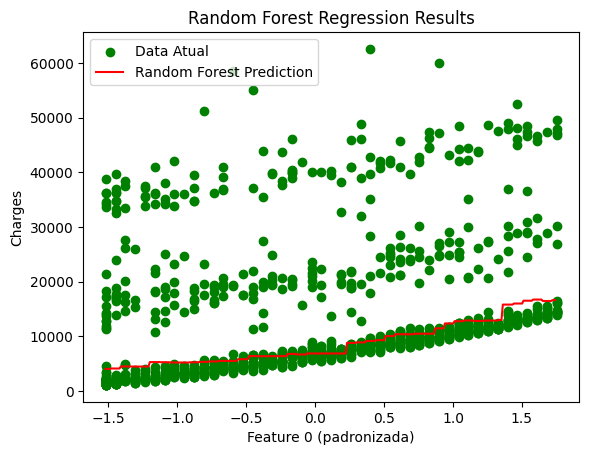

In [70]:
X_grid = np.arange(min(X_train_scaled[:, 0]), max(X_train_scaled[:, 0]), 0.01).reshape(-1, 1)
X_grid = np.hstack((X_grid, np.zeros((X_grid.shape[0], X_train_scaled.shape[1] - 1))))

plt.scatter(X_train_scaled[:, 0], y_train, color='green', label="Data Atual")
plt.plot(X_grid[:, 0], random_forest.predict(X_grid), color='red', label="Random Forest Prediction")
plt.title("Random Forest Regression Results")
plt.xlabel('Feature 0 (padronizada)')
plt.ylabel('Charges')
plt.legend()
plt.show()

#### O modelo está dentro do padrão de média dos valores (linha vermelha)




#### Plotando a árvore de decisão

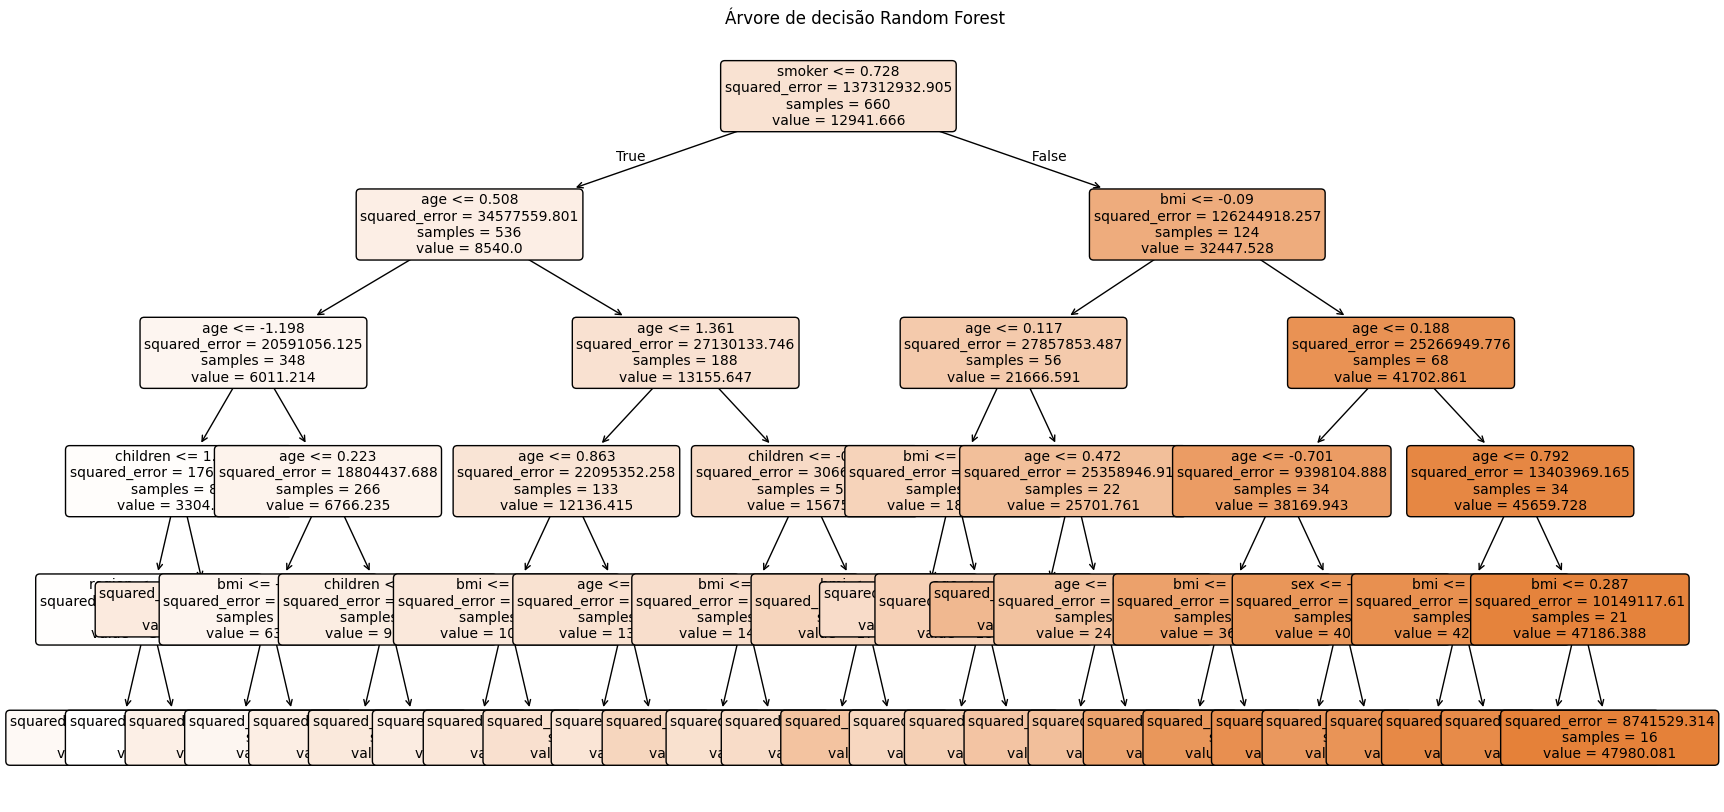

In [72]:
tree_to_plot = random_forest.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=df.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Árvore de decisão Random Forest")
plt.show()

# **Comparação Random Forest VS Regressão Linear**

### Para fins comparativos vamos refazer o treinamento com o modelo de Regressão Linear e comparar os resultados

In [73]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

In [74]:
y_pred_lr = rfe.predict(X_test)

r2_score(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print(f"R²: {r2_lr:.4f}")
print(f"MSE: {mse_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"MAE: {mae_lr:.4f}")

R²: 0.7833
MSE: 33635210.4312
RMSE: 5799.5871
MAE: 4186.5089


### Analisando o resultado de resíduos e predições de cada modelo

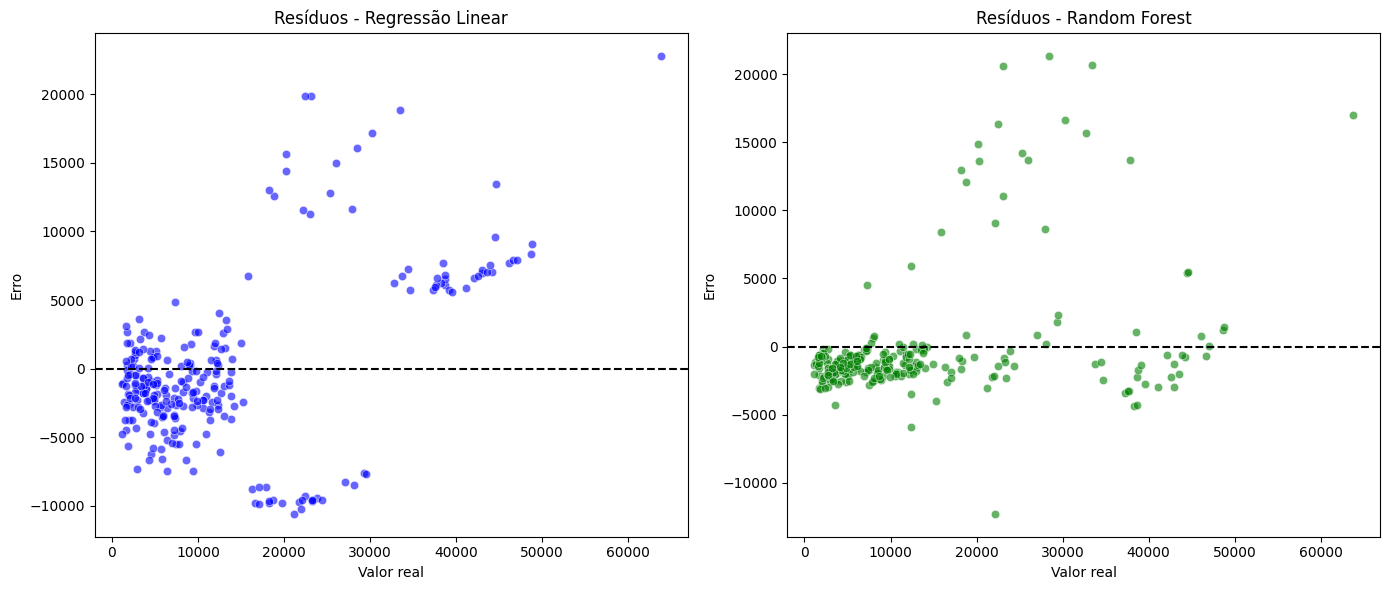

In [75]:
residuals_lr = y_test - y_pred_lr
residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=residuals_lr, color="blue", alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.title("Resíduos - Regressão Linear")
plt.xlabel("Valor real")
plt.ylabel("Erro")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=residuals_rf, color="green", alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.title("Resíduos - Random Forest")
plt.xlabel("Valor real")
plt.ylabel("Erro")

plt.tight_layout()
plt.show()

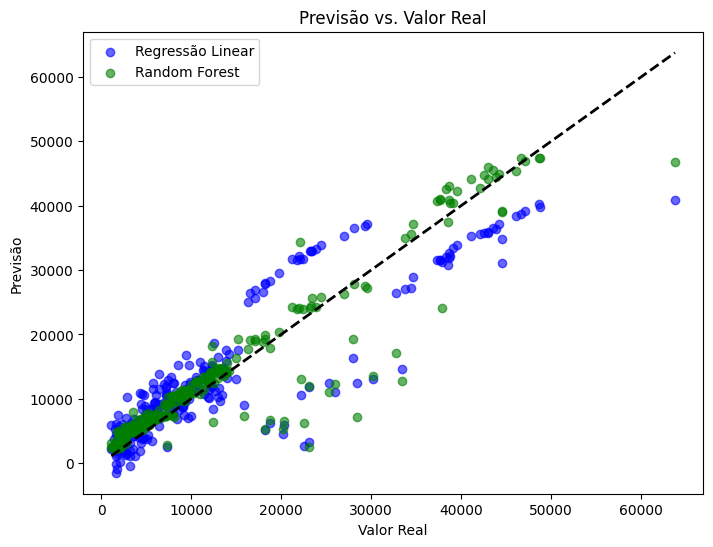

In [76]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.6, color='blue', label='Regressão Linear')
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='green', label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Previsão')
plt.title('Previsão vs. Valor Real')
plt.legend()
plt.show()

In [77]:
comparison = pd.DataFrame({
    "Modelo": ["Regressão Linear", "Random Forest"],
    "R²": [r2_lr, r2_rf],
    "MAE": [mae_lr, mae_rf],
    "MSE": [mse_lr, mse_rf],
    "RMSE": [rmse_lr, rmse_rf]
})
comparison

,Modelo,R²,MAE,MSE,RMSE
0,Regressão Linear,0.783346,4186.508898,3.363521e+07,5799.587091
1,Random Forest,0.878451,2479.237131,1.887034e+07,4343.999940


## Conclui-se que o modelo de Random Forest foi muito mais performático para a resolução do problema apresentado.

# **Exportando o modelo para API**

### Exportando o modelo para consumo em uma API através de um pipeline que segue os passos executados até aqui

In [79]:
from sklearn.pipeline import Pipeline
import joblib

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(
        random_state=0,
        oob_score=True,
        n_jobs=-1,
        n_estimators=100,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features=1.0,
        max_depth=5,
        criterion='squared_error'
    ))
])

pipeline.fit(X_train, y_train)

if not os.path.exists('./model'):
    os.makedirs('./model')

joblib.dump(pipeline, './model/pipeline_rf.joblib')

['./model/pipeline_rf.joblib']

#### Agora você pode carregar o arquivo `pipeline_rf.joblib` em sua API e fazer previsões diretamente, sem se preocupar em escalar os dados manualmente.